In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


Początkowo po przeanalizowaniu danych, potrzebne było uzupełnienie niektórych pól, których nie udało się wydobyć poprzez scrapping. 
Przykładowe pola typu ilość klocków w zestawie, trzeba było uzupełnić sprawdzając ich ilość na obrazku opakowania. 
Niektóre zestawy typu "bundle" nie miały podanych ilości klocków przez co nie będzie brany pod uwagę.

In [7]:
lego_sets = pd.read_csv('scrapped_set_lego.csv', index_col='title', delimiter=';')
lego_sets['age'].unique()

lego_sets['normal_price'], lego_sets['promo_price'] = lego_sets['price'].str.extract('(\d+,\d+)', expand=True), lego_sets['price'].str.split(', ').str.get(1).str.extract('(\d+,\d+)', expand=True)
lego_sets['normal_price'], lego_sets['promo_price'] = lego_sets['normal_price'].str.replace(',','.'), lego_sets['promo_price'].str.replace(',','.')
lego_sets = lego_sets.replace('None',np.NaN)
lego_sets['normal_price'] = lego_sets['normal_price'].astype(float) 
lego_sets['promo_price'] = lego_sets['promo_price'].astype(float)
lego_sets['pieces'] = lego_sets['pieces'].astype(float)
lego_sets


,category,price,age,pieces,item,normal_price,promo_price
title,,,,,,,
Creative animals,DUPLO®,"['269,99']",1½+,175.0,10934,269.99,NaN
Wild Animals of Asia,DUPLO®,"['469,99']",2+,117.0,10974,469.99,NaN
Wild Animals of the World,DUPLO®,"['599,99']",2+,140.0,10975,599.99,NaN
Wild Animals of Africa,DUPLO®,"['45,99']",2+,10.0,10971,45.99,NaN
My First Puppy & Kitten With Sounds,DUPLO®,"['179,99']",1½+,22.0,10977,179.99,NaN
...,...,...,...,...,...,...,...
Orchid,LEGO® ICONS™,"['239,99']",18+,608.0,10311,239.99,NaN
Back to the Future Time Machine,LEGO® ICONS™,"['799,99']",18+,1872.0,10300,799.99,NaN
LEGO® Titanic,LEGO® ICONS™,"['2999,99']",18+,9090.0,10294,2999.99,NaN


Przy scrappingu niektóre zestawy pojawiały się w zbiorze kilkukrotnie, należy je oczyścić z powtórzonych wierszy. Dodatkowo dokonywane jest czyszczenie zestawów bez podanych liczby kloców.

In [8]:
lego_sets.drop_duplicates(subset=['item'], inplace=True)
lego_sets.dropna(subset = ['pieces'], inplace=True)
lego_sets


,category,price,age,pieces,item,normal_price,promo_price
title,,,,,,,
Creative animals,DUPLO®,"['269,99']",1½+,175.0,10934,269.99,NaN
Wild Animals of Asia,DUPLO®,"['469,99']",2+,117.0,10974,469.99,NaN
Wild Animals of the World,DUPLO®,"['599,99']",2+,140.0,10975,599.99,NaN
Wild Animals of Africa,DUPLO®,"['45,99']",2+,10.0,10971,45.99,NaN
My First Puppy & Kitten With Sounds,DUPLO®,"['179,99']",1½+,22.0,10977,179.99,NaN
...,...,...,...,...,...,...,...
Orchid,LEGO® ICONS™,"['239,99']",18+,608.0,10311,239.99,NaN
Back to the Future Time Machine,LEGO® ICONS™,"['799,99']",18+,1872.0,10300,799.99,NaN
LEGO® Titanic,LEGO® ICONS™,"['2999,99']",18+,9090.0,10294,2999.99,NaN


In [9]:
lego_sets["age"].unique()

def set_age_category(age):
    if age in ('1½+', '2+', '3+', '2-5', '2-6', '3-6'):
        return '1.5+'
    elif age in ('5+', '4+', '4-99', '5-12'):
        return '4+'
    elif age in ('7+', '8+', '6+', '6-12', '7-12', '8-14'):
        return '6+'
    elif age in ('10+', '9+', '11+', '12+'):
        return '9+'
    elif age in ('14+', '16+'):
        return '13+'
    elif age == '18+':
        return '18+'
    else:
        return 'other'

lego_sets['age_category'] = lego_sets['age'].apply(set_age_category)

fig = px.histogram(lego_sets, x="age_category", title="Counts of Age dedicated sets")
fig.show()


Duża większość zestawów zaczyna się dla dzieci powyżej 6 roku życia. Ciekawe jest, że blisko 100 zestawów dedykowana jest wyłącznie dorosłym osobom.

In [32]:
lego_sets_count = lego_sets.groupby('category').count()
fig = px.pie(lego_sets_count.reset_index(), values='item', names='category',
             title='Category popularity')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()


In [27]:
lego_sets_mean = lego_sets.groupby('category').mean()

fig = px.bar(lego_sets_mean.reset_index(), x="category", y="normal_price", 
                 color="normal_price", barmode="group")
fig.show()

fig = px.bar(lego_sets_mean.reset_index(), x="category", y="pieces", 
                 color="pieces", barmode="group")
fig.show()

lego_sets_mean['price_by_pieces'] = lego_sets_mean['normal_price']/lego_sets_mean['pieces']

fig = px.bar(lego_sets_mean.reset_index(), x="category", y="price_by_pieces", 
                 color="price_by_pieces", barmode="group")
fig.show()

Można zauważyć, że wykresy są zanieczyszczone przez produkty typu wieszak z klocków Lego, lub elektryczne klocki Lego. Takich produktów nie chcemy na wykresie.

In [14]:

lego_sets_no_trash = lego_sets[lego_sets['category'].str.contains('INVALID|MINDSTORMS|Powered')==False]
lego_sets_no_trash_mean = lego_sets_no_trash.groupby('category').mean()

fig = px.bar(lego_sets_no_trash_mean.reset_index(), x="category", y="normal_price", 
                 color="normal_price", barmode="group")
fig.show()

fig = px.bar(lego_sets_no_trash_mean.reset_index(), x="category", y="pieces", 
                 color="pieces", barmode="group")
fig.show()

lego_sets_no_trash_mean['price_by_pieces'] = lego_sets_no_trash_mean['normal_price']/lego_sets_no_trash_mean['pieces']

fig = px.bar(lego_sets_no_trash_mean.reset_index(), x="category", y="price_by_pieces", 
                 color="price_by_pieces", barmode="group")
fig.show()


Z lekko oczyszczonego wykresu widzimy, że nadal pozostaje nam pare irracjonalnie kosztownych pozycji typu Lego Education w których też znajdują się elementy elektryczne. Uwage może zwrócić wysoka cena klocków Duplo, które lekko różnią się od standardowych. 

Dodatkowo można zauważyć, że ceny zestawów licencjonowanych są lekko droższe niż te oryginalne.

In [17]:
lego_sets_no_special = lego_sets[lego_sets['category'].str.contains('INVALID|MINDSTORMS|Powered|DUPLO|Education|Minifigures')==False]
lego_sets_no_special_mean = lego_sets_no_special.groupby('category').mean()

lego_sets_no_special_mean['price_by_pieces'] = lego_sets_no_special_mean['normal_price']/lego_sets_no_special_mean['pieces']

fig = px.bar(lego_sets_no_special_mean.reset_index(), x="category", y="price_by_pieces", 
                 color="price_by_pieces", barmode="group")
fig.show()

In [19]:
X = lego_sets.pieces.values
y = lego_sets.normal_price.values

X_no_special = lego_sets_no_special.pieces.values
y_no_special = lego_sets_no_special.normal_price.values

X = X.reshape(-1,1)
X_no_special = X_no_special.reshape(-1,1)


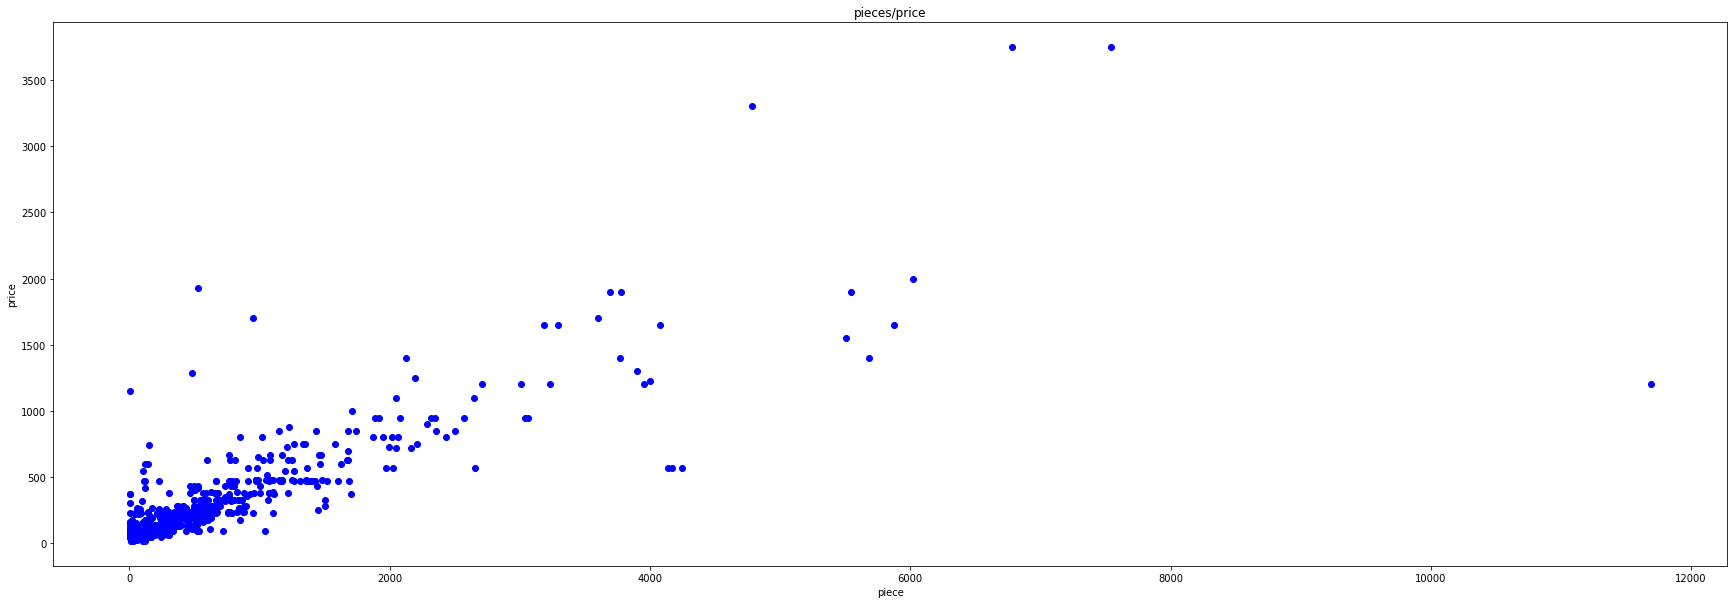

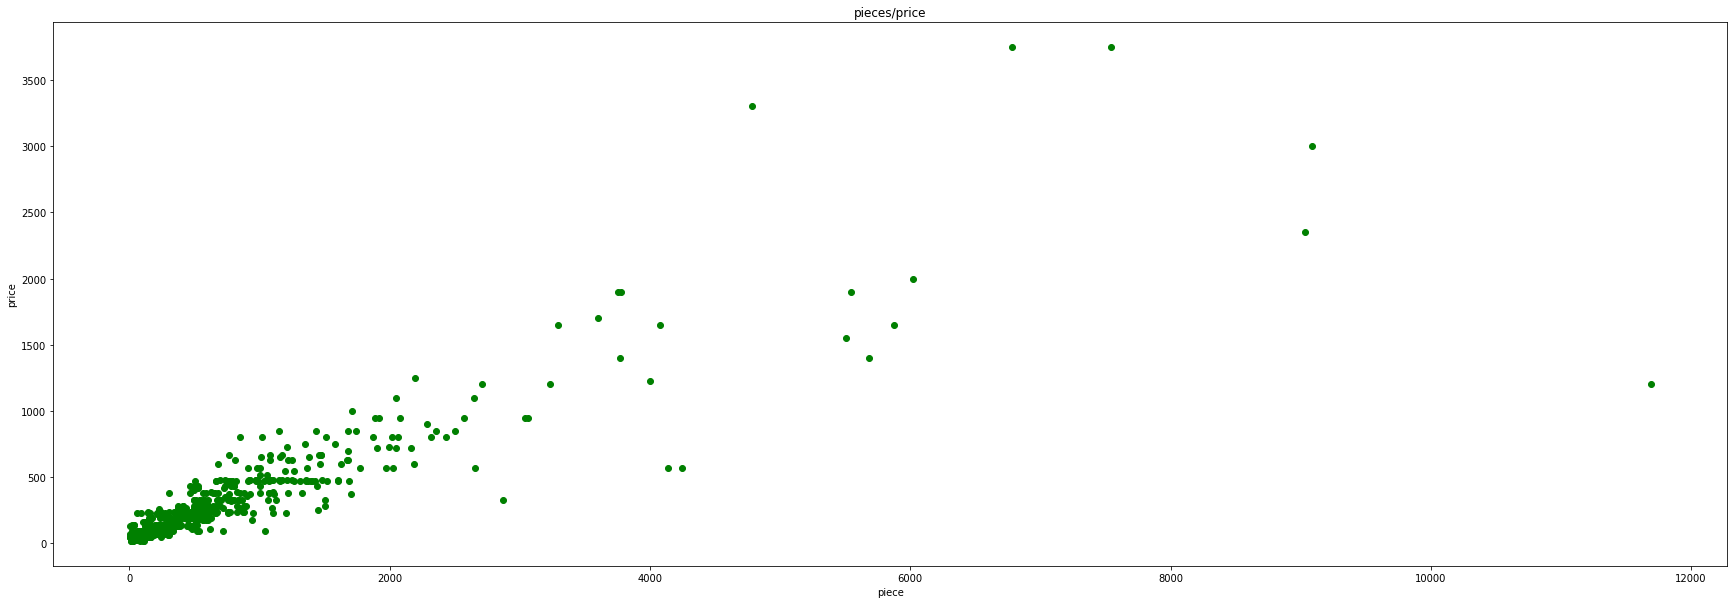

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)
x_train_no_special, x_test_no_special, y_train_no_special, y_test_no_special = train_test_split(X_no_special, y_no_special, train_size=0.8, test_size=0.2, random_state=100)

%matplotlib inline
plt.rcParams["figure.figsize"] = [30, 10]
plt.scatter(x_train, y_train, color='blue')
plt.xlabel('piece')
plt.ylabel('price')
plt.title('pieces/price')
plt.show()

%matplotlib inline
plt.rcParams["figure.figsize"] = [30, 10]
plt.scatter(x_train_no_special, y_train_no_special, color='green')
plt.xlabel('piece')
plt.ylabel('price')
plt.title('pieces/price')
plt.show()

Training Data Accuracy: 67.82%
Predictive Data Accuracy: 77.92%


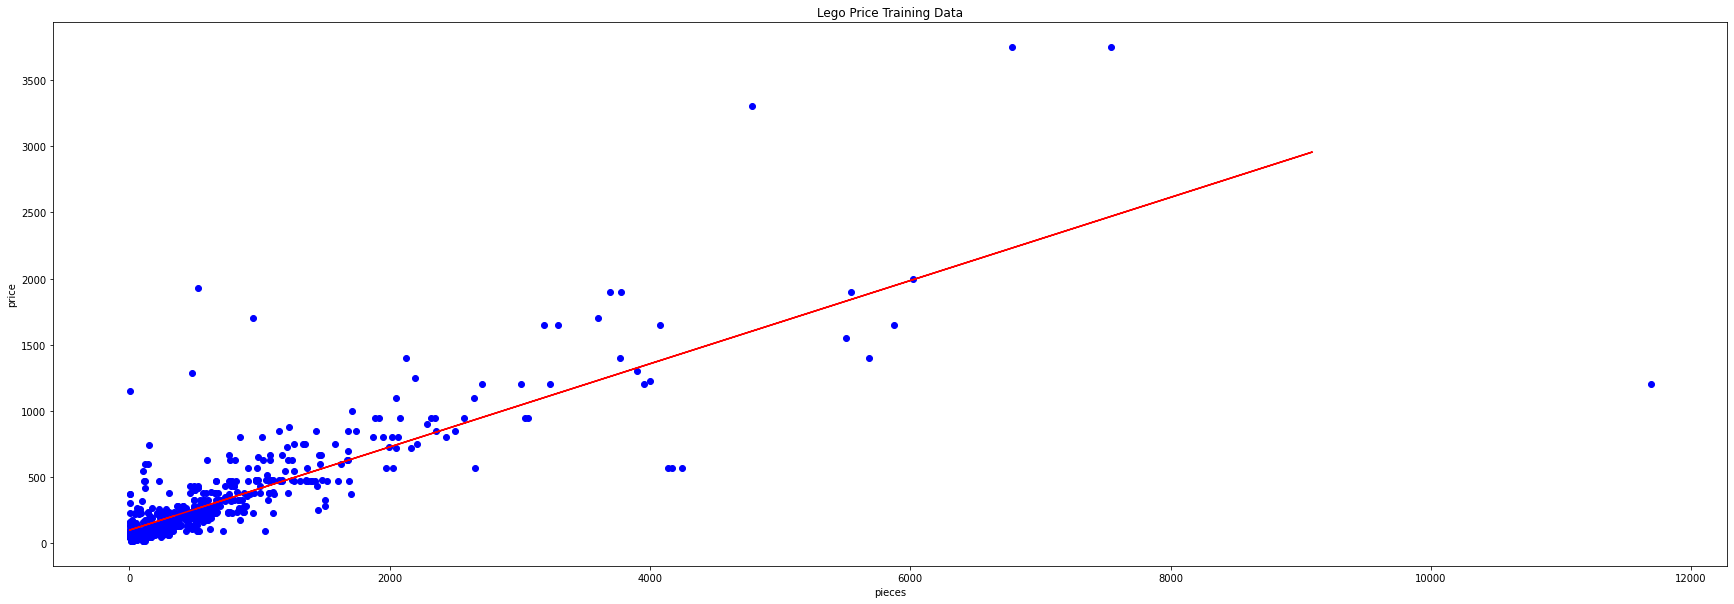

Training Data Accuracy: 76.19%
Predictive Data Accuracy: 79.35%


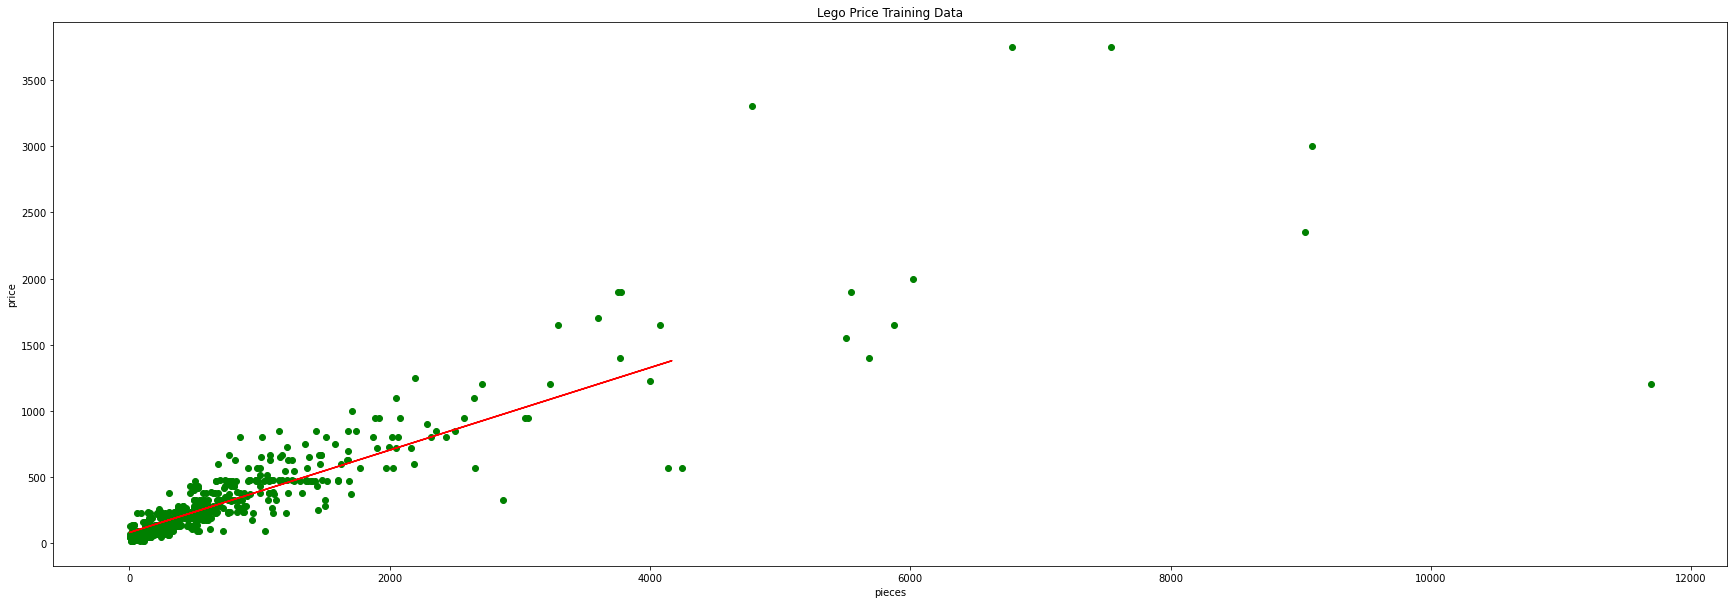

In [33]:
lm = LinearRegression()
lm.fit(x_train, y_train)
y_predict = lm.predict(x_test)

train_acc = round(lm.score(x_train, y_train) * 100, 2)
test_acc = round(lm.score(x_test, y_test) * 100, 2)
print(f'Training Data Accuracy: {train_acc}%')
print(f'Predictive Data Accuracy: {test_acc}%')

plt.scatter(x_train, y_train, color='blue')
plt.plot(x_test, y_predict, color = 'red')
plt.xlabel('pieces')
plt.ylabel('price')
plt.title('Lego Price Training Data')
plt.show()

lm = LinearRegression()
lm.fit(x_train_no_special, y_train_no_special)
y_predict_no_special = lm.predict(x_test_no_special)

train_acc = round(lm.score(x_train_no_special, y_train_no_special) * 100, 2)
test_acc = round(lm.score(x_test_no_special, y_test_no_special) * 100, 2)
print(f'Training Data Accuracy: {train_acc}%')
print(f'Predictive Data Accuracy: {test_acc}%')

plt.scatter(x_train_no_special, y_train_no_special, color='green')
plt.plot(x_test_no_special, y_predict_no_special, color = 'red')
plt.xlabel('pieces')
plt.ylabel('price')
plt.title('Lego Price Training Data')
plt.show()

Odrzucając niestandardowe klocki wynik regresji wzrasta o 10%, co jest średnim wynikiem